In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_frames(frames, frames_2, act_ps, acts, act_m, fs, titles, max_f=None):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(17, 5))
    ax1.set_title('Frame')
    im = ax1.imshow(frames[0][-1], cmap='gray', vmin=0, vmax=1, animated=True)
    ax2.set_title('Pred Frame')   
    im_2 = ax2.imshow(frames_2[0][-1], cmap='gray', vmin=0, vmax=1, animated=True)

    ax3.set_title(titles[0], fontsize=8)
    bars = ax3.bar(act_m, act_ps[0])
    for bar in bars:
            bar.set_color('blue')
    # Highlight the selected bar in red
    bars[acts[0]].set_color('red')
    
    ax3.set_xlabel('Action')
    ax3.set_ylabel('Probability')    
    ax3.set_ylim(0, 1)
    ax3.set_xticks(ax3.get_xticks())
    ax3.set_xticklabels(ax3.get_xticks(), rotation='vertical')
    
    ax4.set_title('f Values')
    fs = np.array(fs)
    fs[np.isnan(fs)] = 0.
    if max_f is None: max_f = np.max(fs)         
    ax4.set_ylim(np.min(fs), max_f)  # Set y-axis limits
    trail_t = 20
    trail_nan = np.zeros((fs.shape[0], trail_t))
    fs = np.concatenate([trail_nan, fs], axis=1)

    lines = [ax4.plot(fs[0, :trail_t], label=f'Line {i}')[0] for i in range(fs.shape[0])]
    ax4.legend()

    def update(n):
        im.set_array(frames[n][-1])
        im_2.set_array(frames_2[n][-1])
        ax3.set_title(titles[n], fontsize=8)

        for i, bar in enumerate(bars):
            bar.set_height(act_ps[n][i])  # Update the height with the new data
        # Reset all bars to a default color
        for bar in bars:
            bar.set_color('blue')
        # Highlight the selected bar in red
        bars[acts[n]].set_color('red')

        for i, line in enumerate(lines):
            line.set_ydata(fs[i, n:n+trail_t])

        return [im, im_2, bars] + lines

    ani = FuncAnimation(fig, update, frames=range(len(frames)), interval=100)
    return ani

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.nn import functional as F
from thinker.main import Env
import thinker.util as util
from thinker.self_play import init_env_out, create_env_out
from thinker.actor_net import ActorNet
from thinker import self_play
from thinker.learn_actor import cur_reward_norm
import gym
import os 

__project__ = "thinker"

xpid = "v16b16_0.001nc"
ckp = xpid is not None
savedir = "../logs/__project__"
savedir = savedir.replace("__project__", __project__)

if ckp:
    ckpdir = os.path.join(savedir, xpid)      
    if os.path.islink(ckpdir): ckpdir = os.readlink(ckpdir)  
    ckpdir =  os.path.abspath(os.path.expanduser(ckpdir))

max_eps_n = 1
flags = util.create_setting(args=[], savedir=savedir, xpid=xpid, ckp=ckp, save_flags=False)

seed = 1
env = Env(
    name=flags.name,
    env_n=1,
    base_seed=seed,        
    gpu=False,
    train_model=False,
    parallel=False,
    savedir=savedir,        
    xpid=xpid,
    ckp=ckp,
    return_x=True,
    save_flags=False,
    rec_t=1,
    )

state = env.reset()
env_out = init_env_out(state, flags)
#util.plot_raw_state(state["real_states"][0][:3])
#util.plot_raw_state(state["xs"][0][-3:])

num_actions = env.num_actions
obs_space = env.observation_space
action_space = env.action_space  

actor_param = {
            "obs_space":obs_space,
            "action_space":action_space,
            "flags":flags
        }

actor_net = ActorNet(**actor_param)
if xpid is not None:
    checkpoint = torch.load(
            os.path.join(flags.ckpdir, "ckp_actor.tar"), torch.device("cpu")
        )
    actor_net.set_weights(checkpoint["actor_net_state_dict"])
actor_state = actor_net.initial_state(batch_size=1)

am = gym.make(flags.name).unwrapped.get_action_meanings()
act_m = []
for n, a in enumerate(am): act_m.append(a)
print(act_m)

/home/scuk/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-09 17:04:17,931	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.

Initializing env 0 with device cpu
A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
Detected frame stacking with 4 counts


Loaded config from ../logs/thinker/v16b16_0.001nc/config_c.yaml
Loaded config from ../logs/thinker/v16b16_0.001nc/config_c.yaml


Model network size: 12826742
Loaded model net from /mnt/c/Users/chung/Personal/RS/thinker/logs/thinker/v16b16_0.001nc/ckp_model.tar


['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


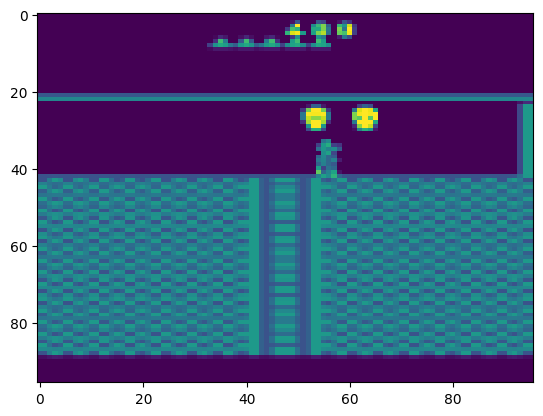

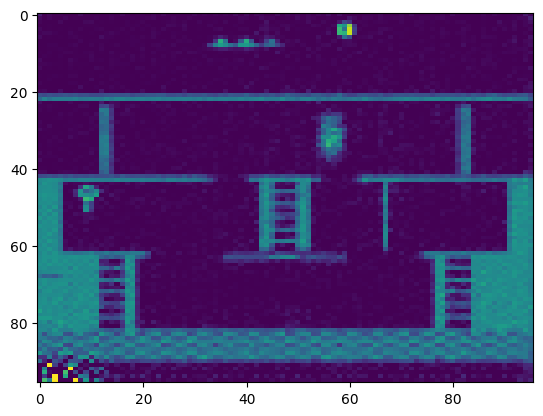

In [4]:
fixed_action = True
max_k = 200

env.seed([1])
state = env.reset()
env_out = init_env_out(state, flags)

xs = []
pred_xs = []
im_xs = []
raw_cur_rs = []
cur_rs = []
test_rs = []
cur_enc_losses = []
cur_img_losses = []
cur_true_pi_losses = []
cur_pi_losses = []
cur_v_losses = []
cur_vs = []
dones = []
act_ps = []
acts = []
titles = []

last_model_logits = None

real_as = [0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 11, 11, 0, 0, 0, 11, 11, 0, 0, 0, 0, 3, 5, 5, 5, 5, 5, 5]
real_as += [5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 12, 12, 12, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2]
real_as += [2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 1, 0, 0, 0, 0, 0, 0, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 11, 11, 3, 3, 3,]
real_as += [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 12, 12, 0, 0, 12, 12, 0, 0, 4, 4, 4, 4]
real_as += [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 11, 11, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
real_as += [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0]

po = lambda x: torch.clamp(x, 0., 1.).detach()
env.model_net.train(False)
torch.set_printoptions(precision=4, sci_mode=False)

k = 0
while(True):
    if fixed_action:
        pri = torch.tensor([real_as[k]])
        reset = torch.tensor([0])
        action = (pri, reset)
    i = 0
    while(True):
        actor_out, actor_state = actor_net(
                    env_out, actor_state, greedy=False
                )        
        if not fixed_action:
            action = actor_out.action        
        state, reward, done, info = env.step(*action)   
        env_out = self_play.create_env_out(action, state, reward, done, info, flags)
        cur_reward, _ = cur_reward_norm(info['cur_reward'], checkpoint["crnorm"], info["cur_gate"], flags)
        if done[0]: print(info["cur_episode_return"].item())
        if info['step_status'] == 0: break
        if i == 0: im_xs.append(state["xs"][0][-1:])
        i += 1    
    act_ps.append(actor_out.action_prob[-1, 0].detach().cpu().numpy())
    acts.append(action[0].item())

    if len(acts) >= 2:
        a = torch.tensor(acts[-2:], dtype=torch.int64, device=state["xs"].device).unsqueeze(-1)
        trues = env.model_net.forward(x=state["xs"], actions=a[-1:], normalize=False, ret_hs=True, ret_zs=True, ret_xs=True) 
        preds = env.model_net.forward(x=last_x, actions=a, normalize=False, ret_hs=True, ret_zs=True, ret_xs=True, future_xs=state["xs"].unsqueeze(0))   

        true_z = trues.zs[-1]
        pred_z = preds.zs[-1]
        cur_enc_loss = torch.mean(torch.square(true_z - pred_z), dim=(1, 2, 3)).item()          

        true_x = trues.xs[-1]
        pred_x = preds.xs[-1]
        cur_img_loss = torch.mean(torch.square(true_x - pred_x), dim=(1, 2, 3)).item()    

        log_probs = F.log_softmax(preds.logits[-1], dim=-1)
        target_log_probs = F.log_softmax(trues.logits[-1], dim=-1)           
        cur_pi_loss = F.kl_div(log_probs, target_log_probs, reduction='none', log_target=True)
        cur_pi_loss = torch.sum(cur_pi_loss, dim=-1).item()

        if last_model_logits is not None:
            log_probs = F.log_softmax(last_model_logits, dim=-1)       
            target_log_probs = F.log_softmax(actor_out.misc["pri_logits"][-1], dim=-1)    
            #print("Pred ", torch.exp(log_probs).detach())
            #print("Actu ", torch.exp(target_log_probs).detach())
            cur_true_pi_loss = F.kl_div(log_probs, target_log_probs, reduction='none', log_target=True)
            cur_true_pi_loss = torch.sum(cur_true_pi_loss, dim=-1).item()
        else:
            cur_true_pi_loss = 0

        cur_v_loss = env.model_net.compute_vs_loss(
            vs = preds.vs,
            v_enc_logits = preds.v_enc_logits,
            target_vs = trues.vs
        ).item()        
        pred_xs.append(po(preds.xs[-1, 0, -1:]))
        last_model_logits = trues.logits[-1]
        test_r = 0
    else:        
        pred_xs.append(po(torch.zeros_like(state["xs"][0, -1:])))
        test_r = 0
        cur_enc_loss = 0        
        cur_img_loss = 0
        cur_pi_loss = 0        
        cur_true_pi_loss = 0
        cur_v_loss = 0

    cur_vs.append(actor_out.baseline[:,:,-1].item())
    raw_cur_rs.append(info['cur_reward'].item())
    cur_rs.append(cur_reward.item())
    cur_enc_losses.append(cur_enc_loss)
    cur_img_losses.append(cur_img_loss)
    cur_pi_losses.append(cur_pi_loss)
    cur_true_pi_losses.append(cur_true_pi_loss)
    cur_v_losses.append(cur_v_loss)
    test_rs.append(test_r)
    dones.append(done.item())    
    last_x = state["xs"]
    xs.append(po(state["xs"][0]))
    title = f"r: {cur_rs[-1]:.4f} d: {'Y' if dones[-1] else 'N'} v: {cur_vs[-1]:.4f} tr: {test_r:.4f}"
    titles.append(title)

    k += 1
    if fixed_action:
        if k >= len(real_as): break
    else:
        if k > max_k: break

cur_true_pi_losses = cur_true_pi_losses[1:]
cur_true_pi_losses.append(0.)

util.plot_raw_state(xs[-1][-1:])       
util.plot_raw_state(pred_xs[-1][-1:])   

rets = []
trail_ret = 0

for i in range(len(dones) - 1, -1, -1):
    done = dones[i]
    cur_r = cur_rs[i]
    if done: trail_ret = 0
    trail_ret = flags.discounting * trail_ret + cur_r
    rets.append(trail_ret)

rest = rets.reverse()
for i in range(len(dones)):
    titles[i] += f" g: {rets[i]:.4f}"

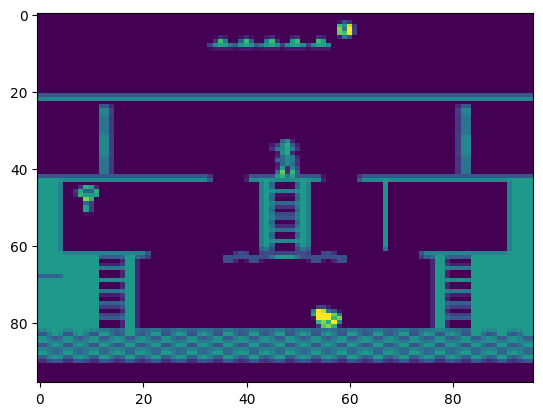

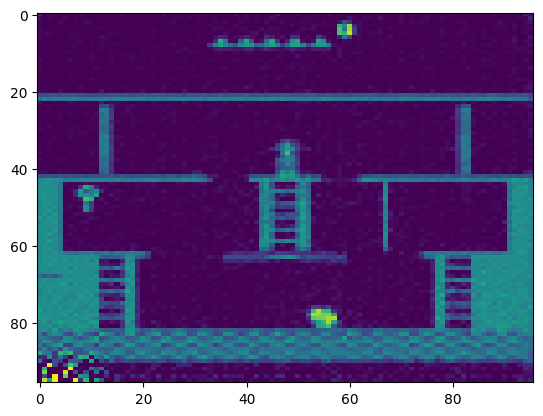

In [8]:
test_x = xs[-1].unsqueeze(0)
test_a = torch.tensor([acts[-1], 2], dtype=torch.int64, device=state["xs"].device).unsqueeze(-1)
test_out = env.model_net.forward(x=test_x, actions=test_a, normalize=False, ret_hs=True, ret_zs=True, ret_xs=True) 
test_out_xs = torch.clamp(test_out.xs,0,1)[:,0,-1:]
for k in test_out_xs:
    util.plot_raw_state(k)


In [ ]:
matplotlib.rcParams['animation.embed_limit'] = 2**128
fs = [cur_enc_losses, cur_pi_losses, cur_true_pi_losses, cur_v_losses, raw_cur_rs, cur_img_losses]
fs = [cur_enc_losses, raw_cur_rs]

ani = animate_frames(xs, pred_xs, act_ps, acts, act_m, fs, titles, max_f=None)
HTML(ani.to_jshtml())

In [ ]:
import torch
import time

def nearest_neighbor_L2_distance(xs, data):
    """
    Compute the L2 distance between each data point in xs and each point in a batch of data points, using GPU.
    Then find the minimum distance for each point in xs efficiently without loops.
    Args:
    xs (torch.Tensor): A batch of data points with shape (16, 32, 9, 9).
    data (torch.Tensor): A batch of data points with shape (B, 32, 9, 9).

    Returns:
    torch.Tensor: A tensor containing the minimum L2 distances for each point in xs.
    """
    with torch.no_grad():
        # Expand xs and data to broadcastable shapes
        xs_expanded = xs.unsqueeze(1)  # Shape: (16, 1, 32, 9, 9)
        data_expanded = data.unsqueeze(0)  # Shape: (1, B, 32, 9, 9)

        # Compute the squared L2 distance
        print("computing squared difference")
        distances = torch.sum((data_expanded - xs_expanded) ** 2, dim=(2, 3, 4)).sqrt()

        # Find the minimum distance for each x in xs
        min_distances = torch.min(distances, dim=1)[0]
    return min_distances

device = torch.device("cuda")

# Example usage
B = 20000  # Example batch size
xs = torch.randn(32, 32, 9, 9, dtype=torch.float16)  # Random data point
data = torch.randn(B, 32, 9, 9, dtype=torch.float16)  # Random batch of data points
print("data moved")

# Moving data to GPU
xs = xs.to(device)
data = data.to(device)

for _ in range(100):
    # Measure the time taken to compute the L2 distance
    start_time = time.time()
    new_data = torch.randn(32, 32, 9, 9, dtype=torch.float16).to(device)
    data = torch.concatenate([data[32:], new_data], dim=0)
    distances = nearest_neighbor_L2_distance(xs, data)
    # Computing the minimum distance from the distances tensor
    min_distance = torch.min(distances)
    min_distance.item()  # Convert to a Python float for readability
    end_time = time.time()

    elapsed_time = end_time - start_time
    print(elapsed_time)




In [7]:
am = gym.make('MontezumaRevengeNoFrameskip-v4').unwrapped.get_action_meanings()
for n, a in enumerate(am): print(n, a)

0 NOOP
1 FIRE
2 UP
3 RIGHT
4 LEFT
5 DOWN
6 UPRIGHT
7 UPLEFT
8 DOWNRIGHT
9 DOWNLEFT
10 UPFIRE
11 RIGHTFIRE
12 LEFTFIRE
13 DOWNFIRE
14 UPRIGHTFIRE
15 UPLEFTFIRE
16 DOWNRIGHTFIRE
17 DOWNLEFTFIRE


In [94]:
from thinker.model_net import RVTran
rv_tran = RVTran(enc_type=3, enc_f_type=1)
x = torch.tensor([-0.1], dtype=torch.float)
rv_tran.encode(x)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0953, 0.9047, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])